# Twitter Multithreading  Multi-Network Crawl/Query => Graph

## i. Load & Initialize

In [1]:
#!pip install python-decouple
import json
import tweepy
import re
from collections import Counter
import time
from decouple import config
import trio
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

## ii. Load Twitter Credentials

In [2]:
# if running in colab, upload `.env` as `env` then run:
#!mv env .env

#Load Twitter Credentials File
TWITTER_AUTH = tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
TWITTER = tweepy.API(TWITTER_AUTH)

## 1. Capture current TwiterAPI rate limit status

In [3]:
# Check the limit before running the function, then check again after and compare. 
start_api_check = TWITTER.rate_limit_status()
limits_alpha = json_normalize(start_api_check)

## 2.  Function: Retrieve User Interactions

In [4]:
def get_user_interactions(list_dict):
    """Crawls the targeted user's timeline and returns interactions.
    Args:
        `search`, string: The name of the user who's timeline to search.
        `output`, list of tuples: paired list of search & interaction targets. 
        `next_query`, list: a list of names to search on the next run. 
        `limit`, int: A flag to indicate how many results should be returned. 
    
    Functionality:
        Initialize search for the specific user.
        Get the user's tweets from their timeline. 
        Cycle through all the tweets' text and join it into a mega-string.
        Do some standardizing and replacing.
        Strip away everything except usernames, into a string. 
        Make a list of the counts, and take the top (X) most common people. 
        Creates a list of the `top` people. No duplicates 
        Tuple the results of the search & output together.
        Make search inputs for the next level of crawling.
    
    Returns:
        This function is async and has no return statement, rather it 
        instead updates the values of `output` and `next_query` extending
        the lists that were passed to it as args.
    """
    search, output, found, limit = list_dict
    try:
        twitter_user = TWITTER.get_user(search)
        tweets = twitter_user.timeline(
                    count=200,
                    exclude_replies=False,
                    include_rts=True,
                    tweet_mode='extended'
        )
        b = [ i.full_text for i in tweets ]
        b = " ".join(b)
        b = b.lower()
        b = b.replace(search, "")
        out = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
        top = Counter(out).most_common(limit)

        if limit > 0:
            interactions = []
            for interaction_count in top:
                interactions += ([interaction_count[0]] * interaction_count[1])

            tweet_data = [(search, i) for i in interactions]
            output.extend(tweet_data)

            found_users = [person[0] for person in top]
            found.extend(found_users)

        elif limit == -1: 
            tweet_data = [(search, i) for i in out]
            output = output.extend(tweet_data)
            
            found_users = [person[0] for person in top]
            found.extend(found_users)
    
    except tweepy.TweepError:
        print("tweepy.TweepError=")
        
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)

## 2. Multithreaded multi-query using python futures to retrieve data

In [5]:
def interaction_chain():
    from concurrent.futures import ThreadPoolExecutor as PoolExecutor
    """Calls our async function & loops through it for each target user."""
    # input settings
    origin_user = ['bwinterrose']
    first_users = ['austen','paulg','justinkhan','tommycollison',"lambdaschool"]
    first_limit = 100 # -1 is no limit, anything above 1 sets limit.
    second_limit = -1 # -1 is no limit, anything above 1 sets limit. 
    third_limit = 5
    
    # init function variables
    data = []
    lvl = 0
    last_lvl = 2 # Set to number of levels. 
    
    start_time = time.time()
    last_time = time.time()
    
    s_users = [] # Passed into the active loops for each level.  
    f_users = first_users # Gathered from each loop cycle for the current level. 
    p_users = origin_user # Current users deposited after llvl, used to clean out next users.

    # Updates the time for each loop.
    def funct_time(last, d, l):
        now = time.time()
        check_time = now - last
        print("\n\nLevel %s Completed\nLevel %s time to complete: %s." % (l, l, check_time))
        print("Level %s total cumulative interactions found:", (l, len(d)))
        return now
    
    # Dedupe & Check user list for previous runs (no duplicated work). 
    def update_lists(ss_users, ff_users, pp_users, llvl, llst_lvl):
        ff_users = list(dict.fromkeys(ff_users)) # Dedupe f_users. 
        pp_users += ss_users # Deposit last search(ed)_users into p_users. (input to last run)
        for i in pp_users: # Remove p_users from f_users.
            a = np.array(ff_users) 
            a = a[a != i] 
            ff_users = a.tolist() 
        ss_users = ff_users #Overwrite ss_users list with cleaned ff_users loop output. 
        ff_users = [] #Reset ff_users for next run.
        if llvl == 0: # on first run.... 
            llvl += 1 
            print("----------Entering %sst level. Searching the following users:----------\n" % llvl, ss_users)
        else: # on other runs...
            print("Level %s new connections found:" % llvl, len(ss_users), "\n\n")
            print("Total %s connections discovered so far." % (len(pp_users)+len(ss_users)))
            if llvl < llst_lvl:
                llvl += 1
                print("---------Beginning Level %s - Searching the following users:\n" % llvl, ss_users)
        return ss_users, ff_users, pp_users, llvl
    
    # Pre-run print. 
    s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  
        
    # Level 1 Run.
    loop_num = 1
    with PoolExecutor(max_workers=20) as executor:
        for _ in executor.map(get_user_interactions, [(x, data, f_users, first_limit) for x in s_users]):
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            pass
    
    last_time = funct_time(last_time, data, lvl)
    s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  


    # Level 2 Run.
    loop_num = 1
    with PoolExecutor(max_workers=20) as executor:
        for _ in executor.map(get_user_interactions, [(x, data, f_users, first_limit) for x in s_users]):
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            pass

    last_time = funct_time(last_time, data, lvl)
    s_users, f_users, p_users, lvl = update_lists(s_users, f_users, p_users, lvl, last_lvl)  

    
    print("Total time:", time.time() - start_time)
    print("Total Connections found:", (len(p_users)-1))
    print("Total Overall Interactions found:", len(data))
    return data

## 3. Call the `multithreaded` function. 
Notice the errors are handeled in the output.

In [6]:
data = interaction_chain()

----------Entering 1st level. Searching the following users:----------
 ['austen', 'paulg', 'justinkhan', 'tommycollison', 'lambdaschool']
Loop #  1  . Time so far: 0.9947471618652344
Loop #  2  . Time so far: 0.9960329532623291
Loop #  3  . Time so far: 0.9966812133789062
Loop #  4  . Time so far: 1.0626702308654785
Loop #  5  . Time so far: 1.0628032684326172


Level 1 Completed
Level 1 time to complete: 1.0642449855804443.
Level %s total cumulative interactions found: (1, 830)
Level 1 new connections found: 322 


Total 328 connections discovered so far.
---------Beginning Level 2 - Searching the following users:
 ['kevinsimler', 'amasad', 'webdevmason', 'wrathofgnon', 'atabarrok', 'mckaywrigley', 'lpolovets', 'maxcroser', 'stephansturges', 'zewesk', 'jeremymclellan', 'mikegee', 'paulskallas', 'andrewsshi', 'andreasklinger', 'spectrumofnate', 'barabasicsongor', 'keith_wasserman', 'robertkwolek', 'tylercowen', 'haribelafonte07', 'nikolaytsenkov', 'macaesbruno', 'dcnovember', 'jessliv

Loop #  67  . Time so far: 7.06386399269104
Loop #  68  . Time so far: 7.1426990032196045
Loop #  69  . Time so far: 7.296756267547607
Loop #  70  . Time so far: 7.298898220062256
Loop #  71  . Time so far: 8.347246170043945
Loop #  72  . Time so far: 8.351450204849243
Loop #  73  . Time so far: 8.351640224456787
Loop #  74  . Time so far: 8.351826190948486
Loop #  75  . Time so far: 8.351966142654419
Loop #  76  . Time so far: 8.352052927017212
Loop #  77  . Time so far: 8.352179288864136
Loop #  78  . Time so far: 8.35486102104187
Loop #  79  . Time so far: 8.355769157409668
Loop #  80  . Time so far: 8.355879306793213
Loop #  81  . Time so far: 8.355993032455444
Loop #  82  . Time so far: 8.356234312057495
Loop #  83  . Time so far: 8.356874942779541
Loop #  84  . Time so far: 8.35699725151062
Loop #  85  . Time so far: 8.357107162475586
Loop #  86  . Time so far: 8.357213258743286
Loop #  87  . Time so far: 8.452219247817993
Loop #  88  . Time so far: 8.504059076309204
Loop #  89  

Loop #  243  . Time so far: 18.781615257263184
Loop #  244  . Time so far: 18.78236413002014
Loop #  245  . Time so far: 19.009342193603516
Loop #  246  . Time so far: 19.00989007949829
Loop #  247  . Time so far: 19.00996708869934
Loop #  248  . Time so far: 19.010066270828247
Loop #  249  . Time so far: 19.010167121887207
Loop #  250  . Time so far: 19.209476232528687
Loop #  251  . Time so far: 19.259470224380493
Loop #  252  . Time so far: 19.299822092056274
Loop #  253  . Time so far: 19.302512168884277
Loop #  254  . Time so far: 19.3025860786438
Loop #  255  . Time so far: 19.4013831615448
Loop #  256  . Time so far: 19.51910924911499
Loop #  257  . Time so far: 19.521557331085205
Loop #  258  . Time so far: 19.52218222618103
Loop #  259  . Time so far: 19.553967237472534
Loop #  260  . Time so far: 19.586414098739624
Loop #  261  . Time so far: 19.658300161361694
tweepy.TweepError=
Loop #  262  . Time so far: 20.521079063415527
Loop #  263  . Time so far: 20.557469129562378
Loo

## 4. Prep the data for conversion into a `networkx MultiDiGraph` object

In [13]:
%%time
# DF before Groupby
df = pd.DataFrame(data, columns=['source_user', 'interaction_user'])
display(df.shape)
display(df.head(5))

# Create groupby counts
df_group = df.groupby(['source_user','interaction_user']).size().reset_index().rename(columns={0: "count"})
display(df_group.head())
display(df_group.shape)

# Create "Normalized" interaction weights for each user's interactions. 
a = df_group.groupby('source_user')['count'].transform('sum')
df_group['weight'] = df_group['count'].div(a)
display(df_group.head())
display(df_group.shape)

(60681, 2)

,source_user,interaction_user
0,paulg,austen
1,paulg,austen
2,paulg,austen
3,paulg,austen
4,paulg,austen


,source_user,interaction_user,count
0,aarjav,aaron_crum,3
1,aarjav,abhicvk,2
2,aarjav,adamsinger,1
3,aarjav,addiane,1
4,aarjav,alexisohanian,5


(28281, 3)

,source_user,interaction_user,count,weight
0,aarjav,aaron_crum,3,0.014286
1,aarjav,abhicvk,2,0.009524
2,aarjav,adamsinger,1,0.004762
3,aarjav,addiane,1,0.004762
4,aarjav,alexisohanian,5,0.023810


(28281, 4)

CPU times: user 78.9 ms, sys: 6.18 ms, total: 85.1 ms
Wall time: 81.9 ms


## 5. Convert the Pandas Dataframe to Networkx Graph

In [14]:
%%time
# Create the graph object 
DG = nx.from_pandas_edgelist(df_group, "source_user", "interaction_user",
                            edge_attr=['weight', "count"], 
                             create_using=nx.MultiGraph())

# Check how many nodes are on the graph now. 
bicomponents = list(nx.biconnected_components(DG))
len(bicomponents)

CPU times: user 4.55 s, sys: 14.7 ms, total: 4.56 s
Wall time: 4.56 s


In [15]:
%%time
bicomponents = list(nx.biconnected_components(DG))
len(bicomponents)

CPU times: user 4.32 s, sys: 7.35 ms, total: 4.33 s
Wall time: 4.33 s


## 7. Query TwitterAPI and Inspect Rate Usage

In [16]:
# Query API 
end_api_check = TWITTER.rate_limit_status()
limits_beta = json_normalize(end_api_check).T
limits_beta.rename(columns = {0:'beta',}, inplace = True)

# Compare the change of ALL API ENDPOINTS between limits, alpha (before run), and beta (after run.)
limits_delta = limits_alpha.T.copy()
limits_delta['beta'] = limits_beta['beta']
limits_delta = limits_delta.reset_index(drop=False)
limits_delta.rename(columns = {0:'alpha', 'index':'api_endpoint'}, inplace = True)
limits_delta = limits_delta[['api_endpoint','alpha', 'beta']].assign(delta=limits_delta.alpha != limits_delta.beta)
limits_delta['type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 1, expand = True)[0]
limits_delta['sub_type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[1]
limits_delta['api_path'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[2].str.rsplit(pat = '.', n = 1, expand = True)[0]
limits_delta['method'] = limits_delta.api_path.str.rsplit(pat = '/', n = 1, expand = True)[1]
limits_delta['stat'] = limits_delta.api_endpoint.str.rsplit(pat = '.', n = 1, expand = True)[1]
limits_delta = limits_delta[['type', 'sub_type', 'api_path', 'method', 'stat', 'alpha', 'beta', 'delta']]

# Display filtered df. 
limits_delta[(limits_delta['stat'].str.contains("reset") == False) & (limits_delta['delta']==True)]


,type,sub_type,api_path,method,stat,alpha,beta,delta
50,resources,application,/application/rate_limit_status,rate_limit_status,remaining,178,176,True
365,resources,statuses,/statuses/user_timeline,user_timeline,remaining,574,248,True
431,resources,users,/users/show/:id,:id,remaining,573,246,True


## 6. Graph the Networkx graph objects. 

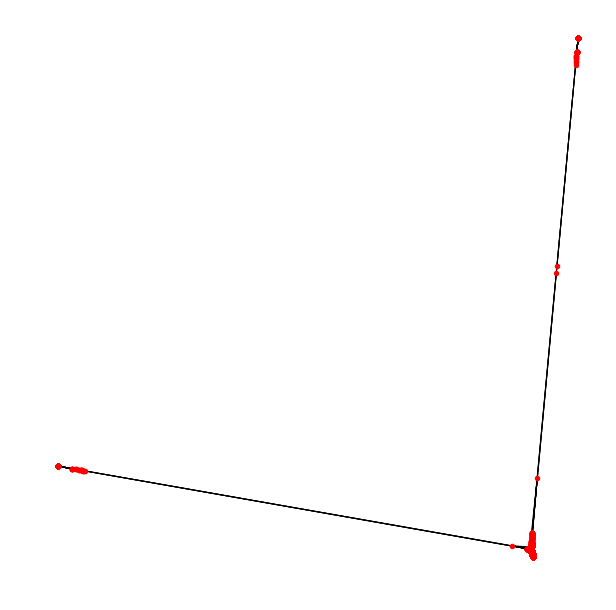

CPU times: user 52.4 s, sys: 677 ms, total: 53.1 s
Wall time: 14.1 s


In [17]:
%%time
fig = plt.figure(figsize=(8,8))
nx.draw_spectral(DG, node_size=20)
plt.show()

In [11]:
# %%time
# fig = plt.figure(figsize=(8,8))
# nx.draw_kamada_kawai(DG,node_size=20,with_labels=True)
# plt.show()